In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pandas as pd
import numpy as np
import gensim
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.datasets import fetch_20newsgroups
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

2017-06-07 23:28:40,306 : INFO : 'pattern' package found; tag filters are available for English


In [2]:
newsgroups_train_meta = fetch_20newsgroups(subset='train')

## Categorias dos textos

In [3]:
pprint(list(newsgroups_train_meta.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


### Vamos ver um texto de Motos

In [4]:
newsgroups_train_meta.target_names[newsgroups_train_meta.target[10]]

'rec.motorcycles'

In [5]:
newsgroups_train_meta.data[10]

u'From: irwin@cmptrc.lonestar.org (Irwin Arnstein)\nSubject: Re: Recommendation on Duc\nSummary: What\'s it worth?\nDistribution: usa\nExpires: Sat, 1 May 1993 05:00:00 GMT\nOrganization: CompuTrac Inc., Richardson TX\nKeywords: Ducati, GTS, How much? \nLines: 13\n\nI have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs\nvery well, paint is the bronze/brown/orange faded out, leaks a bit of oil\nand pops out of 1st with hard accel.  The shop will fix trans and oil \nleak.  They sold the bike to the 1 and only owner.  They want $3495, and\nI am thinking more like $3K.  Any opinions out there?  Please email me.\nThanks.  It would be a nice stable mate to the Beemer.  Then I\'ll get\na jap bike and call myself Axis Motors!\n\n-- \n-----------------------------------------------------------------------\n"Tuba" (Irwin)      "I honk therefore I am"     CompuTrac-Richardson,Tx\nirwin@cmptrc.lonestar.org    DoD #0826          (R75/6)\n------------------------------------------

### Agora um de computação

In [6]:
newsgroups_train_meta.target_names[newsgroups_train_meta.target[1]]

'comp.sys.mac.hardware'

In [7]:
newsgroups_train_meta.data[1]

u"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.\n\nGuy Kuo <guykuo@u.washington.edu>\n"

### Remover os headers, footers e quotes dos textos (Metadados que não vão nos interessar hoje)

In [8]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

### Mesmo texto de computação

In [9]:
newsgroups_train.data[1]

u"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks."

Bem melhor o/

### Tokenização + Limpeza + Stopwords

Atenção! Cada problema que envolve texto exige um tratamento diferente nesta etapa. Ex. Caso o seu problema envolva análise de sentimento pode não ser uma boa ideia remover pontuação.

O pacote nltk tem bastante coisa de NLP que iremos aproveitar - tem algumas coisas para o português também!

In [10]:
def clean_and_tokenizing(text):
    # Remove numbers + punctuation        
    letters_only = re.sub("[^a-zA-Z]", " ", text) 

    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                             

    # Save english stopwords
    stops = set(stopwords.words("english"))                  

    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    
    # Join everython again
    return( " ".join( meaningful_words ))   

In [11]:
num_text = len(newsgroups_train.data)

print "Cleaning and parsing...\n"
clean_texts = []
for i in xrange(0, num_text):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print "Review %d of %d\n" % ( i+1, num_text )
    clean_texts.append(clean_and_tokenizing(newsgroups_train["data"][i]))

Cleaning and parsing...

Review 1000 of 11314

Review 2000 of 11314

Review 3000 of 11314

Review 4000 of 11314

Review 5000 of 11314

Review 6000 of 11314

Review 7000 of 11314

Review 8000 of 11314

Review 9000 of 11314

Review 10000 of 11314

Review 11000 of 11314



In [12]:
clean_texts[1]

u'fair number brave souls upgraded si clock oscillator shared experiences poll please send brief message detailing experiences procedure top speed attained cpu rated speed add cards adapters heat sinks hour usage per day floppy disk functionality floppies especially requested summarizing next two days please add network knowledge base done clock upgrade answered poll thanks'

### Bag of Words

Primeiro vamos comparar as dimensões de um BoW com limpeza de um BoW sem limpeza:

#### Original

In [13]:
# Initialize the "CountVectorizer" is the bag of words

vectorizer = CountVectorizer(analyzer = "word")

train_data_features = vectorizer.fit_transform(newsgroups_train["data"])

train_data_features = train_data_features.toarray()

Perceba que o resultado tem 11314 documentos e 101631 palavras

In [14]:
print train_data_features.shape

(11314, 101631)


#### Clean

In [15]:
# Initialize the "CountVectorizer" is the bag of words

vectorizer = CountVectorizer(analyzer = "word")
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_texts)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Perceba que o resultado tem 11314 documentos e 72772 palavras - Uma redução de 28%!

In [16]:
print train_data_features.shape

(11314, 72772)


In [17]:
feature_names = vectorizer.get_feature_names() 
feature_names[50:70]

[u'aavb',
 u'aavso',
 u'aaw',
 u'aax',
 u'aayau',
 u'aazo',
 u'ab',
 u'aba',
 u'ababs',
 u'abacus',
 u'abaihm',
 u'abandon',
 u'abandond',
 u'abandoned',
 u'abandoning',
 u'abandons',
 u'abatement',
 u'abates',
 u'abba',
 u'abbasids']

In [18]:
train_data_features[1]

array([0, 0, 0, ..., 0, 0, 0])

### Stemming

In [19]:
def stem(text):
    # Split into individual words
    words = text.split()                             

    # Save english stopwords
    snowball = SnowballStemmer("english")

    # Remove stop words
    stem_words = []
    for w in words:
        stem_words.append(snowball.stem(w))
    
    return( " ".join(stem_words))  

In [20]:
num_text = len(newsgroups_train.data)

print "Stemming...\n"
stem_texts = []
for i in xrange(0, num_text):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print "Review %d of %d\n" % ( i+1, num_text )
    stem_texts.append(stem(clean_texts[i]))

Stemming...

Review 1000 of 11314

Review 2000 of 11314

Review 3000 of 11314

Review 4000 of 11314

Review 5000 of 11314

Review 6000 of 11314

Review 7000 of 11314

Review 8000 of 11314

Review 9000 of 11314

Review 10000 of 11314

Review 11000 of 11314



#### New BoW with stem

In [21]:
# Initialize the "CountVectorizer" is the bag of words

vectorizer = CountVectorizer(analyzer = "word", max_features=200)
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
stem_train_data_features = vectorizer.fit_transform(stem_texts)

# Numpy arrays are easy to work with, so convert the result to an 
# array
stem_train_data_array = stem_train_data_features.toarray()

Perceba que o resultado tem 11314 documentos e 55593 palavras - Uma redução de 54% do original! (limpeza + stemming)

In [22]:
print stem_train_data_features.shape

(11314, 200)


In [23]:
feature_names = vectorizer.get_feature_names()
feature_names[50:70]

[u'etc',
 u'even',
 u'everi',
 u'exampl',
 u'exist',
 u'fact',
 u'far',
 u'file',
 u'find',
 u'first',
 u'follow',
 u'found',
 u'game',
 u'general',
 u'get',
 u'give',
 u'go',
 u'god',
 u'good',
 u'got']

In [24]:
freqs = [(word, stem_train_data_features.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
#sort from largest to smallest
pprint(sorted (freqs[:20], key = lambda x: -x[1]))

[(u'one', 6781),
 (u'also', 3352),
 (u'go', 2959),
 (u'year', 2866),
 (u'could', 2537),
 (u'want', 2436),
 (u'problem', 2316),
 (u'much', 2104),
 (u'said', 1743),
 (u'key', 1667),
 (u'start', 1398),
 (u'still', 1395),
 (u'last', 1373),
 (u'anoth', 1216),
 (u'world', 1076),
 (u'gun', 1065),
 (u'someon', 1015),
 (u'chip', 969),
 (u'disk', 851),
 (u'address', 845)]


### Word Cloud - Facilita a visualização

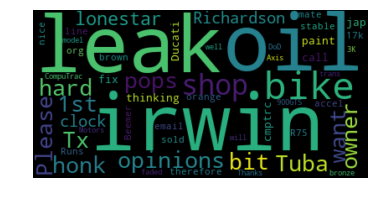

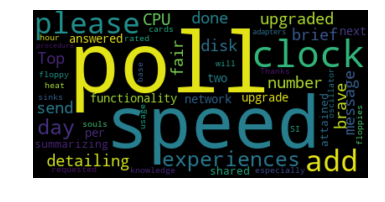

In [25]:
wordcloud = WordCloud().generate(newsgroups_train["data"][10])

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=100).generate(newsgroups_train["data"][1])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### TDF-IDF

In [26]:
vectorizer = TfidfVectorizer(encoding='utf-8')
tfidf = vectorizer.fit_transform(newsgroups_train["data"])

Veja que o tipo do tf-idf é diferente da matriz de frequência

In [27]:
tfidf[1]

<1x101631 sparse matrix of type '<type 'numpy.float64'>'
	with 69 stored elements in Compressed Sparse Row format>

In [28]:
dense = tfidf.todense()
text = dense[0].tolist()[0]


In [29]:
feature_names = vectorizer.get_feature_names()

In [30]:
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]

In [31]:
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:20]:
   print('{0: <20} {1}'.format(phrase, score)) 

car                  0.4046469917
tellme               0.224203549607
bricklin             0.214774113567
was                  0.208582390198
funky                0.195069480982
60s                  0.18067319754
70s                  0.1789497536
enlighten            0.1789497536
bumper               0.170654974336
the                  0.1642840264
this                 0.164031905254
doors                0.150295204041
anyone               0.143671995335
sports               0.142195035543
specs                0.141855528042
production           0.140228581546
door                 0.128986083534
separate             0.126946415645
engine               0.124585099834
addition             0.122295792192
